# Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv("../Dataset/marketing_campaign.csv", sep='\t') #load data

In [ ]:
df.info() 

Attributes

People

ID: Customer's unique identifier
Year_Birth: Customer's birth year
Education: Customer's education level
Marital_Status: Customer's marital status
Income: Customer's yearly household income
Kidhome: Number of children in customer's household 
Teenhome: Number of teenagers in customer's household
Dt_Customer: Date of customer's enrollment with the company
Recency: Number of days since customer's last purchase
Complain: 1 if the customer complained in the last 2 years, 0 otherwise (boolean)

Products

MntWines: Amount spent on wine in last 2 years
MntFruits: Amount spent on fruits in last 2 years
MntMeatProducts: Amount spent on meat in last 2 years
MntFishProducts: Amount spent on fish in last 2 years
MntSweetProducts: Amount spent on sweets in last 2 years
MntGoldProds: Amount spent on gold in last 2 years
Promotion

NumDealsPurchases: Number of purchases made with a discount
AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise (boolean)
AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise (boolean)
AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise (boolean)
AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise (boolean)
AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise (boolean)
Response: 1 if customer accepted the offer in the last campaign, 0 otherwise (boolean)
Place

NumWebPurchases: Number of purchases made through the company’s website
NumCatalogPurchases: Number of purchases made using a catalogue
NumStorePurchases: Number of purchases made directly in stores
NumWebVisitsMonth: Number of visits to company’s website in the last month

In [ ]:
df

General Clean-up

In [ ]:
#replacing multiple campaign columns with a single column that indicates the success of campaigns
campaigns_dict = dict({"000000": 0, "100000": 1, "010000": 2,
                      "001000": 3, "000100": 4, "000010": 5, "000001": 6})

campains_columns = ["AcceptedCmp1", "AcceptedCmp2",
                    "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"]

drops = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3",
         "AcceptedCmp4", "AcceptedCmp5", "Response", 'campaign_success']

df_transform = df.copy()

df_transform['campaign_success'] = df_transform[campains_columns].astype(
    str).agg("".join, axis=1)

df_transform['campaigns'] = df_transform['campaign_success'].replace(
    campaigns_dict)

df_transform = df_transform.drop(drops, axis=1)

df_transform

In [ ]:
# combine Kidhome and Teenhome into Children column
df_transform['Children'] = df_transform['Kidhome'] + df_transform['Teenhome']
drops = ['Kidhome', 'Teenhome']
df_transform = df_transform.drop(drops, axis=1)

df_transform

In [ ]:
# convert Year_Birth to age, considering the data became available July 2024

df_transform['Age'] = 2024 - df_transform['Year_Birth']
drops = ['Year_Birth']
df_transform = df_transform.drop(drops, axis=1)

df_transform

In [ ]:
# convert dt_customer to tenure, considering the data became available July 2024

# format date as a string

df_transform['Dt_Customer'] = pd.to_datetime(
    df['Dt_Customer'], format='%d-%m-%Y')

# Set the reference date — for April 2024, choose any day (e.g., April 1)
reference_date = pd.to_datetime('2024-04-01')

# Calculate the number of days they've been a customer
df_transform['days_as_customer'] = (
    reference_date - df_transform['Dt_Customer']).dt.days

# drop the original date column
drops = ['Dt_Customer']
df_transform = df_transform.drop(drops, axis=1)

df_transform

In [ ]:
# Rename purchases columns for easier readability and cleaner output

df_transform = df_transform.rename(columns={
    'NumWebPurchases': 'Web',
    'NumCatalogPurchases': 'Catalog',
    'NumStorePurchases': 'Store'
})

# Rename product columns for easier readability and cleaner output
df_transform = df_transform.rename(columns={
    'MntWines': "Wines",
    'MntFruits': 'Fruits',
    'MntMeatProducts': 'Meat',
    'MntFishProducts': 'Fish',
    'MntSweetProducts': 'Sweets',
    'MntGoldProds': 'Gold'
})

df_transform

In [ ]:
# Rename arrays for column Marital_Status for better readability and cleaner output
df_transform['Marital_Status'] = df_transform['Marital_Status'].replace({
    'Divorced': 'Alone',
    'Single': 'Alone',
    'Absurd': 'Alone',
    'YOLO': 'Alone',
    'Widow': 'Alone',
    'Married': 'In couple',
    'Together': 'In couple'
})

# Rename arrays for column Education for better readability and cleaner output
df_transform['Education'] = df_transform['Education'].replace({
    'Graducation': 'UnderGraduate',
    'Graduation': 'UnderGraduate', 
    'PhD': 'PostGraduate',
    'Master': 'PostGraduate',
    'Basic': 'UnderGraduate',
    '2n Cycle': 'UnderGraduate'
})

In [ ]:
# Create a new feature column 'Total Spending' by summing all product spending columns
df_transform['Total Spending'] = (
    df_transform['Fish'] +
    df_transform['Fruits'] +
    df_transform['Gold'] +
    df_transform['Meat'] +
    df_transform['Sweets'] +
    df_transform['Wines']
)

df_transform

Outlier Imputation

In [ ]:
#using mean to replace outliers in Age and Income columns
mean_age = df_transform['Age'].mean()
df_transform.loc[df_transform['Age'] > 120, 'Age'] = mean_age #replace ridiculous ages

mean_income = df_transform['Income'].mean()
df_transform.loc[df_transform['Income'] > 200000, 'Income'] = mean_income #replace outrageous values
df_transform['Income'].fillna(df['Income'].mean(), inplace=True) #replace null values

df_transform

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTERING !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
#copy the transformed dataframe to create a separate clustering dataframe
df_clustering= df_transform.copy()

df_clustering

Scaling & Encoding for Clustering

In [ ]:
# Columns to scale
scale_cols = [
    'Income', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold',
    'NumDealsPurchases', 'Web', 'Catalog', 'Store', 'NumWebVisitsMonth',
    'Age', 'Total Spending', 'campaigns', 'days_as_customer'
]

# Initialize scaler
scaler = StandardScaler()

# Scale and replace the values in-place
df_clustering[scale_cols] = scaler.fit_transform(df_clustering[scale_cols])

df_clustering

In [ ]:
# encode the categorical variables, Education and Marital_Status, to be on 0-1 scale

df_clustering['Education'] = df_clustering['Education'].astype('category').cat.codes
df_clustering['Marital_Status'] = df_clustering['Marital_Status'].astype('category').cat.codes

df_clustering


Final data frames

In [ ]:
# Create a final feature list for Clustering

# drop useless columns Z_CostContact and Z_Revenue
drops = ['Z_CostContact', 'Z_Revenue']
df_clustering = df_clustering.drop(drops, axis=1)

# Save IDs for later use
customer_ids = df_clustering['ID'].copy()

# Drop ID column before clustering
df_clustering = df_clustering.drop(['ID'], axis=1)

df_clustering.columns

READY TO GO

In [ ]:
# clustering happens here

In [ ]:
## Create a empty list to store the k and WSSD values
results = []

# Loop through values of k from 1 to 19
for k in range(1, 20):
    # Initialize and fit the KMeans model
    elbow_kmeans = KMeans(n_clusters=k, random_state=0)
    elbow_kmeans.fit(df_clustering)

    # Store k and WSSD
    results.append({"k": k, "wssd": elbow_kmeans.inertia_})

# Create the DataFrame
df_clustering_ks = pd.DataFrame(results)

c:\Users\Caro Crespo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Caro Crespo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Caro Crespo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Caro Crespo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_in

In [20]:
df_clustering_ks

,k,wssd
0,1,40408.324107
1,2,27983.061829
2,3,24960.411884
3,4,23018.185540
4,5,21996.121696
5,6,21056.922730
6,7,20306.057023
7,8,19663.888855
8,9,19250.529037
9,10,18793.943557


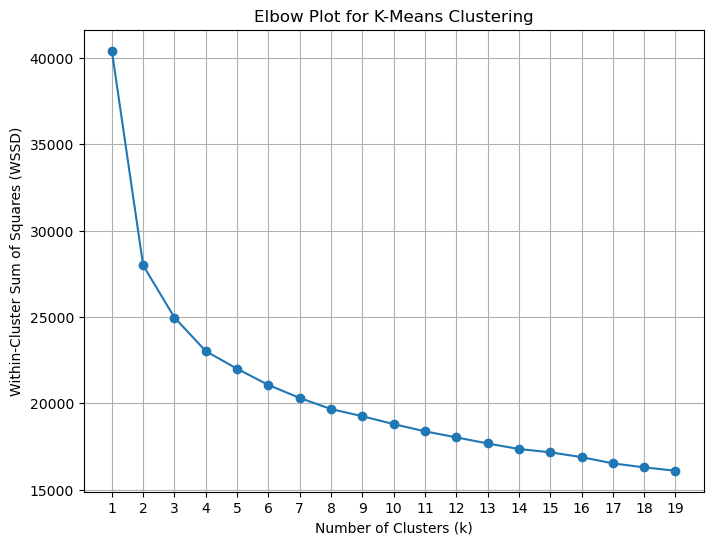

In [21]:
# Create the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(df_clustering_ks['k'], df_clustering_ks['wssd'], marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSSD)')
plt.title('Elbow Plot for K-Means Clustering')
plt.xticks(df_clustering_ks['k'])  # Optional: to ensure all k values are shown on the x-axis
plt.grid(True)
plt.show()

In [22]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(df_clustering)

c:\Users\Caro Crespo\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
# Create a copy of the DataFrame for clustering and modification
df_with_clusters = df_clustering.copy()

# Add cluster labels to the copied DataFrame
df_with_clusters['Cluster'] = clusters.labels_

# Display the updated DataFrame with the 'Cluster' column
df_with_clusters

,Education,Marital_Status,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,Catalog,Store,NumWebVisitsMonth,Complain,campaigns,Children,Age,days_as_customer,Total Spending,Cluster
0,1,0,0.288072,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,...,2.510890,-0.550785,0.693904,0,-0.226444,0,1.017967,1.531185,1.679417,3
1,1,0,-0.263023,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,...,-0.568720,-1.166125,-0.130463,0,-0.226723,2,1.274564,-1.190545,-0.961275,1
2,1,1,0.917714,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,...,-0.226541,1.295237,-0.542647,0,-0.226723,0,0.333707,-0.205773,0.282673,3
3,1,1,-1.183445,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,...,-0.910898,-0.550785,0.281720,0,-0.226723,1,-1.291410,-1.061881,-0.918094,1
4,0,1,0.295315,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,...,0.115638,0.064556,-0.130463,0,-0.226723,1,-1.034813,-0.953012,-0.305254,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1,1,0.432224,-0.107383,1.203678,0.419916,0.066692,0.081926,2.203398,3.891766,...,0.115638,-0.550785,-0.130463,0,-0.226723,1,0.162642,0.135680,1.221032,3
2236,0,1,0.562638,0.237969,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,-0.690659,...,-0.226541,-0.243114,0.693904,0,-0.226677,3,1.958824,-1.655713,-0.268717,0
2237,1,0,0.234009,1.446700,1.795020,0.545656,0.221789,-0.101168,-0.364974,-0.383886,...,0.115638,2.218248,0.281720,0,-0.226537,0,-1.034813,-0.982703,1.054951,3
2238,0,1,0.807065,-1.419719,0.368666,0.092992,0.208495,0.777683,0.071165,0.325527,...,0.799996,1.295237,-0.954831,0,-0.226723,1,1.103499,-0.977755,0.393948,3
